In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, classification_report

import warnings
warnings.filterwarnings('ignore')



In [7]:
# -------- 1. LOAD DATA --------
# Replace with your actual data file path
df = pd.read_csv("amazon.csv")

In [8]:
# -------- 3. DATA PREPROCESSING --------

# Select features and target variable
# predicting rating as regression
target = 'rating'
features = ['category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating_count']

X = df[features]
y = df[target]

# Identify categorical and numeric features
categorical_features = ['category']
numeric_features = ['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']

# Preprocessing pipeline components
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Custom feature engineering (e.g., price difference)
def add_price_diff(X):
    X = X.copy()
    X['price_diff'] = X['actual_price'] - X['discounted_price']
    return X

feature_engineer = FunctionTransformer(add_price_diff)

# Full preprocessing pipeline including feature engineering
full_preprocessing = Pipeline(steps=[
    ('feature_engineering', feature_engineer),
    ('preprocessor', preprocessor)
])



# -------- 4. SPLIT DATA --------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# -------- 5. MODEL DEVELOPMENT --------
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Clean y_train
y_train = y_train.replace('|', np.nan)
y_train = pd.to_numeric(y_train, errors='coerce')
X_train = X_train.loc[y_train.notna()]
y_train = y_train.dropna()

# Clean numeric columns
def clean_to_float(x):
    try:
        return float(re.sub(r'[^\d.-]', '', str(x)))
    except:
        return np.nan

numeric_cols = ['discounted_price', 'actual_price', 'rating_count']
for col in numeric_cols:
    X_train[col] = X_train[col].apply(clean_to_float)
    X_test[col] = X_test[col].apply(clean_to_float)

# Clean and convert percentage
X_train['discount_percentage'] = X_train['discount_percentage'].astype(str).str.replace('%', '', regex=False).astype(float)
X_test['discount_percentage'] = X_test['discount_percentage'].astype(str).str.replace('%', '', regex=False).astype(float)

# Define features
numerical_features = ['discounted_price', 'actual_price', 'discount_percentage', 'rating_count', 'price_diff']
categorical_features = ['category']

# Create function to add price_diff
def add_price_diff(X):
    X = X.copy()
    X['discounted_price'] = pd.to_numeric(X['discounted_price'], errors='coerce')
    X['actual_price'] = pd.to_numeric(X['actual_price'], errors='coerce')
    X['price_diff'] = X['actual_price'] - X['discounted_price']
    return X

price_diff_transformer = FunctionTransformer(add_price_diff)

# Preprocessing for numerical and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing pipeline
full_preprocessing = Pipeline(steps=[
    ('add_price_diff', price_diff_transformer),
    ('column_transform', ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]))
])

# Define models to try
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'LinearRegression': LinearRegression()
}

# Hyperparameter grids for tuning
param_grids = {
    'RandomForest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20],
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    'LinearRegression': {
        # No hyperparameters to tune
    }
}

# Store best estimators
best_estimators = {}

# Loop through models and fit
for name, model in models.items():
    print(f"\nTraining and tuning {name}...")
    
    pipeline = Pipeline(steps=[
        ('preprocessing', full_preprocessing),
        ('model', model)
    ])
    
    param_grid = param_grids.get(name, {})
    
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_estimators[name] = grid_search.best_estimator_
        print(f"Best params for {name}: {grid_search.best_params_}")
        print(f"Best CV score (RMSE): {(-grid_search.best_score_)**0.5:.4f}")
    else:
        pipeline.fit(X_train, y_train)
        best_estimators[name] = pipeline



Training and tuning RandomForest...
Best params for RandomForest: {'model__max_depth': None, 'model__n_estimators': 50}
Best CV score (RMSE): 0.2596

Training and tuning SVR...
Best params for SVR: {'model__C': 1, 'model__kernel': 'rbf'}
Best CV score (RMSE): 0.2600

Training and tuning LinearRegression...



Evaluating RandomForest on test data...
Test RMSE: 0.2611
Test R2: 0.1649
Top features:
               feature  importance
3         rating_count    0.241347
0     discounted_price    0.108637
4           price_diff    0.105894
2  discount_percentage    0.096517
1         actual_price    0.081385


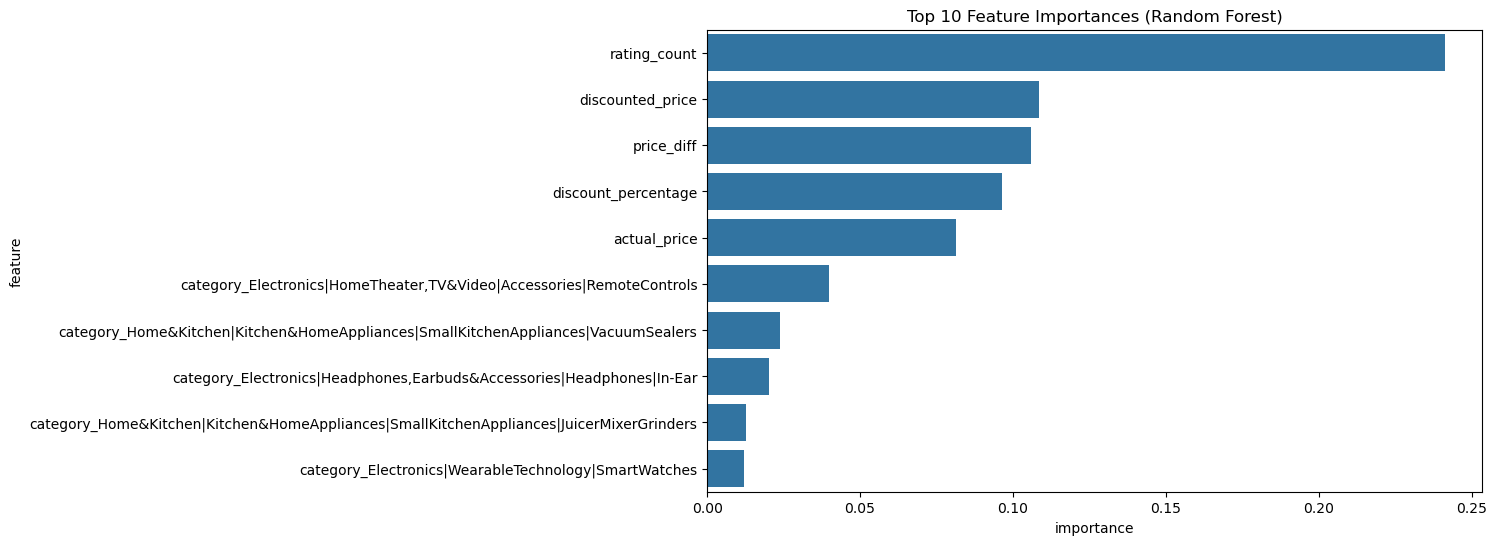


Evaluating SVR on test data...
Test RMSE: 0.2490
Test R2: 0.2405

Evaluating LinearRegression on test data...
Test RMSE: 0.2530
Test R2: 0.2161


In [37]:
# Model evaluation
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    # Loop over each transformer in the ColumnTransformer
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'remainder':
            # Skip remainder transformer (passthrough or drop)
            continue
        # If transformer is a pipeline, get the last step (like OneHotEncoder)
        if hasattr(transformer, 'named_steps'):
            last_step = list(transformer.named_steps.values())[-1]
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(cols)
            else:
                names = cols
        else:
            # For transformers like OneHotEncoder directly
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(cols)
            else:
                names = cols
        feature_names.extend(names)
    return feature_names


for name, model in best_estimators.items():
    print(f"\nEvaluating {name} on test data...")
    y_pred = model.predict(X_test)

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R2: {r2:.4f}")

    if name == 'RandomForest':
        importances = model.named_steps['model'].feature_importances_

        # Extract column transformer from pipeline
        column_transformer = model.named_steps['preprocessing'].named_steps['column_transform']

        # Get all feature names after preprocessing
        all_features = get_feature_names_from_column_transformer(column_transformer)

        if len(all_features) != len(importances):
            print(f"Warning: Number of features ({len(all_features)}) and importances ({len(importances)}) do not match!")

        fi_df = pd.DataFrame({'feature': all_features, 'importance': importances}) \
                .sort_values(by='importance', ascending=False)

        print("Top features:")
        print(fi_df.head())

        plt.figure(figsize=(10,6))
        sns.barplot(x='importance', y='feature', data=fi_df.head(10))
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.show()


In [ ]:
# -------- 7. DOCUMENTATION / COMMUNICATION --------

print("""
Summary:
- Random Forest achieved the best performance with RMSE and R2 scores.
- Key features impacting ratings: discounted price, rating count, discount percentage.
- Further improvements could include text-based sentiment features from reviews.
- The pipeline is reproducible and can be extended with new data or features.
""")